<a href="https://colab.research.google.com/github/kishiyamat/la-kentei-yaminabe/blob/main/notebooks/khoomii_feedback_minimal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 必要なライブラリのインストール
!pip install praat-parselmouth
!pip install pydub

In [2]:
# ライブラリのインポート
import io
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import parselmouth
from pydub import AudioSegment
from pydub.exceptions import CouldntDecodeError
from IPython.display import display, Javascript, clear_output
from google.colab import output
from base64 import b64decode
from skimage.transform import resize
import tempfile
import warnings

# 警告メッセージを非表示にする
warnings.filterwarnings('ignore')

# 録音機能のJavaScriptコード
# 音声を保存する方法は以下のGist, Notebookを参照
# https://gist.github.com/tam17aki/8bfa2a42dab0061ee2641aed32dd1d30
# https://colab.research.google.com/github/espnet/notebook/blob/master/espnet2_asr_realtime_demo.ipynb

RECORD = """
const sleep = time => new Promise(resolve => setTimeout(resolve, time));
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader();
  reader.onloadend = e => resolve(e.srcElement.result);
  reader.readAsDataURL(blob);
});

var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true });

  // MediaRecorderをWebM形式で初期化
  const options = { mimeType: "audio/webm" };
  recorder = new MediaRecorder(stream, options);

  chunks = [];
  recorder.ondataavailable = e => chunks.push(e.data);
  recorder.start();
  await sleep(time);
  recorder.onstop = async () => {
    blob = new Blob(chunks);
    text = await b2text(blob);
    resolve(text);
  };
  recorder.stop();
});
"""


def draw_pitch(pitch_values, pitch_xs, floor=60, ceiling=300):
    plt.plot(pitch_xs, pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(floor, ceiling)
    plt.ylabel("F0[Hz]")


def draw_spectrogram(spectrogram_values, xy_grid: tuple, y_minmax: tuple, dynamic_range=70):
    x_grid, y_grid = xy_grid
    sg_db = 10 * np.log10(spectrogram_values)
    plt.pcolormesh(x_grid, y_grid, sg_db, vmin=sg_db.max()-dynamic_range, cmap='gray_r')
    plt.ylim(y_minmax)
    plt.ylabel("frequency [Hz]")


In [3]:
def feedback(dur=5, res=0.5, figsize = (4, 2)):
    rate = 16_000
    # 番兵(最初に空のデータを作っておく)
    sil_file = "silence.wav"
    parselmouth.Sound(np.zeros(int(dur * rate)), sampling_frequency=rate).save(sil_file, "WAV")
    snd = parselmouth.Sound(sil_file)
    spectrogram = snd.to_spectrogram()
    pitch_values = snd.to_pitch().selected_array['frequency']
    spectrogram_values = spectrogram.values

    while True:
        # Record (binaryから直接読み込んでいる)
        display(Javascript(RECORD))
        flac_buffer = io.BytesIO(b64decode(output.eval_js('record(%d)' % (res * 1000)).split(',')[1]))
        flac_audio = AudioSegment.from_file(flac_buffer, format="webm")
        speech = np.array(flac_audio.get_array_of_samples(), dtype=np.float64)
        speech = librosa.resample(speech, orig_sr=flac_audio.frame_rate, target_sr=rate)
        # 読み込んだ音声の解析
        snd_new = parselmouth.Sound(speech, sampling_frequency=rate)
        # スペクトログラム
        spec_new = snd_new.to_spectrogram()
        _, spec_y = spec_new.values.shape
        spectrogram_values = np.hstack((spectrogram_values[:, spec_y:], spec_new.values))
        # ピッチ
        pitch_new = snd_new.to_pitch().selected_array['frequency']
        pitch_values = np.hstack((pitch_values[pitch_new.shape[0]:], pitch_new))
        # 画面のチラつき防止
        clear_output(wait=True)
        # 描画
        plt.figure(figsize=figsize)
        draw_spectrogram(spectrogram_values=spectrogram_values,
                        xy_grid=(spectrogram.x_grid(), spectrogram.y_grid()),
                        y_minmax=(spectrogram.ymin, spectrogram.ymax),)

        plt.twinx()
        # draw_pitch(pitch_values, pitch.xs())
        draw_pitch(pitch_values, snd.to_pitch().xs())
        plt.xlim([snd.xmin, snd.xmax])
        plt.show()


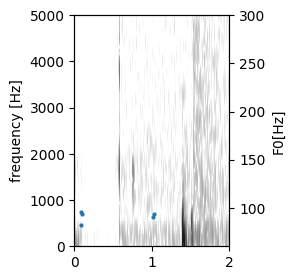

<IPython.core.display.Javascript object>

In [ ]:
# 以下の1, 2 を実行し、3を青い丸と右軸を見ながら調整する
# > 1. 歯の間を指2本分くらい空け、口先をウの形にする。
# > 2. 舌を立て、 舌を軟口蓋と硬口蓋の間ぐらいの位置に近づける。
# > 3. ピアノの中央ドの音のすぐ下のソ（G3）の音ぐらいの高さで「イ」のつもりで発声する。
# 手順4は音程が外れないように注意しながら調整する
# > 4. メロディー音が聞こえたら舌を少しずつ前後に動かしてメロディー音を変える
try:
    feedback(dur=2, res=0.5, figsize=(2, 3))
except CouldntDecodeError:
    # CouldntDecodeError が出たら再度実行する
    feedback(dur=2, res=0.5, figsize=(2, 3))